### Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import graphviz
from sklearn.model_selection import train_test_split ## 訓練、測試切割
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_absolute_percentage_error,mean_squared_error

### Data Preprocessing

In [2]:
train_data = pd.read_csv("adult/adult.data", header= None, names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])

#刪除重複的值
print("原始比數：",train_data.shape)
train_data.drop_duplicates(inplace=True)
train_data = train_data.sort_index(axis=0)
print("刪除重複的值後：",train_data.shape)

#刪除問號的值(取眾數)
vals, counts = np.unique(train_data['workclass'],return_counts=True)
train_data['workclass'] = train_data['workclass'].replace(" ?", vals[np.argmax(counts)])
vals, counts = np.unique(train_data['occupation'],return_counts=True)
train_data['occupation'] = train_data['occupation'].replace(" ?", vals[np.argmax(counts)])
vals, counts = np.unique(train_data['native-country'],return_counts=True)
train_data['native-country'] = train_data['native-country'].replace(" ?", vals[np.argmax(counts)])

# 刪除欄位意義重複的欄位
train_data.drop("education",axis=1,inplace=True)
train_data.drop("fnlwgt",axis=1,inplace=True)

# 每個元素的前後空格去掉
train_data = train_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# 判斷是否還有空值
train_data.isnull().sum(axis=0)

原始比數： (32561, 15)
刪除重複的值後： (32537, 15)


age               0
workclass         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [3]:
## 類別屬性做One-hot Encoding
train_nd = pd.get_dummies(train_data, columns=['workclass','marital-status','occupation','relationship','race','sex','native-country'], dtype=int)

## 數值屬性做Normalization(z-score)
numerical_columns = ['age','education-num','capital-gain','capital-loss']
scaler = preprocessing.StandardScaler()
train_nd[numerical_columns] = scaler.fit_transform(train_nd[numerical_columns])

## 類別屬性(income)做Label Encoding
label_encoder = preprocessing.LabelEncoder()
train_nd["income"] = label_encoder.fit_transform(train_nd["income"])

## 將"&"，改為and，以便作圖
train_nd = train_nd.rename(columns={'native-country_Trinadad&Tobago': 'native-country_Trinadad_and_Tobago'})

In [4]:
test_data = pd.read_csv("adult/adult.test", header= None, names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])
test_data.drop(0,axis=0,inplace=True)
#刪除重複的值
print("原始比數：",test_data.shape)
test_data.drop_duplicates(inplace=True)
test_data = test_data.sort_index(axis=0)
print("刪除重複的值後：",test_data.shape)

#刪除問號的值(取眾數)
vals, counts = np.unique(test_data['workclass'],return_counts=True)
test_data['workclass'] = test_data['workclass'].replace(" ?", vals[np.argmax(counts)])
vals, counts = np.unique(test_data['occupation'],return_counts=True)
test_data['occupation'] = test_data['occupation'].replace(" ?", vals[np.argmax(counts)])
vals, counts = np.unique(test_data['native-country'],return_counts=True)
test_data['native-country'] = test_data['native-country'].replace(" ?", vals[np.argmax(counts)])

# 刪除欄位意義重複的欄位
test_data.drop("education",axis=1,inplace=True)
test_data.drop("fnlwgt",axis=1,inplace=True)

# 每個元素的前後空格去掉
test_data = test_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

def strip_special_chars(value):
    if isinstance(value, str):
        return value.strip(".")
    return value

test_data = test_data.applymap(strip_special_chars)

# 判斷是否還有空值
test_data.isnull().sum(axis=0)

原始比數： (16281, 15)
刪除重複的值後： (16276, 15)


age               0
workclass         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [5]:
## 類別屬性做One-hot Encoding
test_nd = pd.get_dummies(test_data,columns=['workclass','marital-status','occupation','relationship','race','sex','native-country'], dtype=int)
test_nd['native-country_Holand-Netherlands'] = 0

## 類別屬性(income)做Label Encoding
test_nd["income"] = label_encoder.transform(test_nd["income"])

## 數值屬性做Normalization(z-score)
numerical_columns = ['age','education-num','capital-gain','capital-loss']
test_nd[numerical_columns] = scaler.transform(test_nd[numerical_columns])

## 將"&"，改為and，以便作圖
test_nd = test_nd.rename(columns={'native-country_Trinadad&Tobago': 'native-country_Trinadad_and_Tobago'})

### KNN Regression

#### Model Construct&Evaluation

In [6]:
from sklearn.neighbors import KNeighborsRegressor
## 將訓練集與測試集分別切分特徵與目標欄位
train_x = train_nd.drop("hours-per-week",axis=1)
train_y = train_nd['hours-per-week']

test_x = test_nd.drop("hours-per-week",axis=1)
test_y = test_nd['hours-per-week']

train_data_score=[]
R2=[]
RMSE=[]
MAPE=[]
for i in range(25,50,5):
    print("neighbors numbers:",i)
    neigh = KNeighborsRegressor(n_neighbors=i,leaf_size=35,n_jobs=-1)
    neigh.fit(train_x.values, train_y) #Here x.values will have only values without headers
    pred_y=neigh.predict(test_x.values)

    train_data_score_data=neigh.score(train_x.values, train_y)
    train_data_score.append(train_data_score_data)

    R2_data=r2_score(test_y, pred_y)
    R2.append(R2_data)

    RMSE_data=np.sqrt(mean_squared_error(test_y,pred_y))
    RMSE.append(RMSE_data)

    MAPE_data=mean_absolute_percentage_error(test_y,pred_y)
    MAPE.append(MAPE_data)

    print(f"train_data score:{train_data_score_data:.3f}")
    print(f"R2:{R2_data:.5f}")
    print(f"RMSE:{RMSE_data:.5f}")
    print(f"MAPE:{MAPE_data:.5f}%")
    print('------------------------------------------------------')

neighbors numbers: 25
train_data score:0.298
R2:0.24867
RMSE:10.81627
MAPE:0.31006%
------------------------------------------------------
neighbors numbers: 30
train_data score:0.291
R2:0.24854
RMSE:10.81722
MAPE:0.31029%
------------------------------------------------------
neighbors numbers: 35
train_data score:0.286
R2:0.24922
RMSE:10.81233
MAPE:0.31082%
------------------------------------------------------
neighbors numbers: 40
train_data score:0.282
R2:0.24963
RMSE:10.80937
MAPE:0.31120%
------------------------------------------------------
neighbors numbers: 45
train_data score:0.278
R2:0.24968
RMSE:10.80900
MAPE:0.31123%
------------------------------------------------------


#### Plot

Top value:0.299, Bottom value:0.277


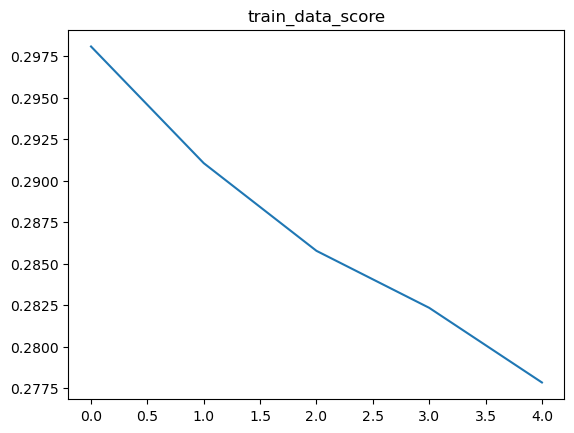

Top value:0.250, Bottom value:0.248


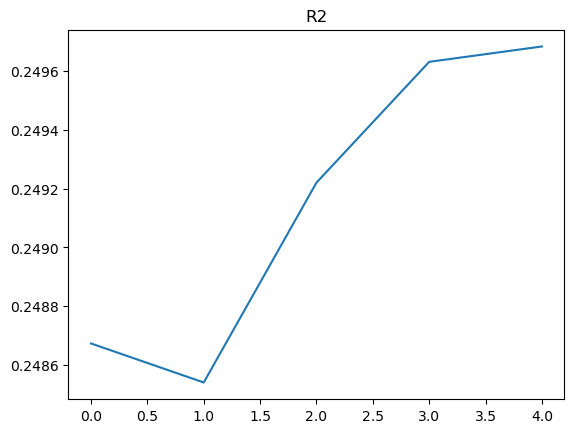

Top value:10.818, Bottom value:10.809


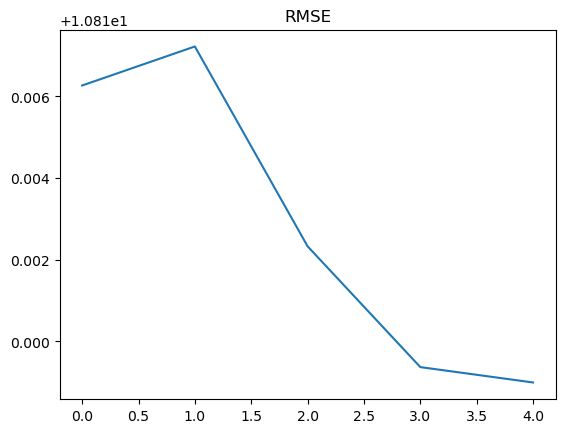

Top value:0.311, Bottom value:0.310


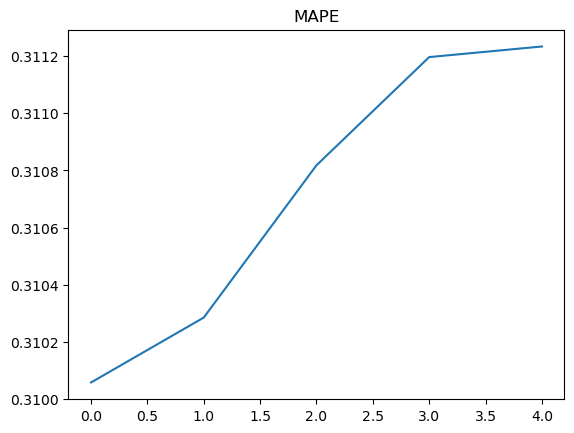

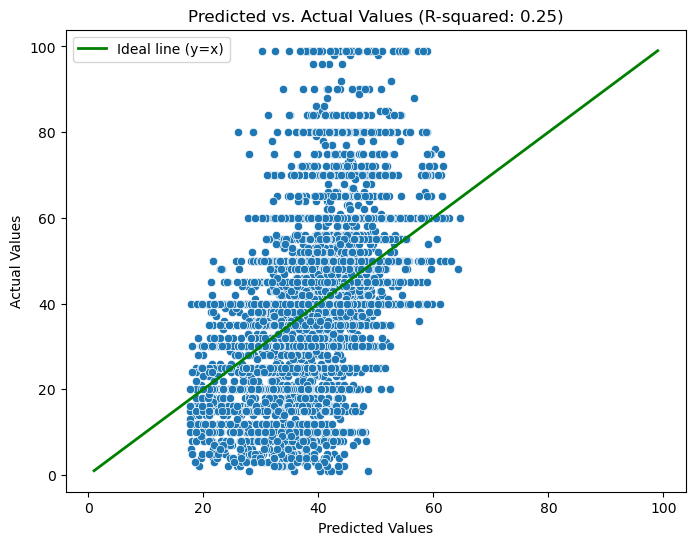

In [7]:
#plot
import seaborn as sns
plt.plot(train_data_score)
bottom,top= plt.ylim()
print(f"Top value:{top:.3f}, Bottom value:{bottom:.3f}")
plt.title('train_data_score')
plt.show()

plt.plot(R2)
bottom,top= plt.ylim()
print(f"Top value:{top:.3f}, Bottom value:{bottom:.3f}")
plt.title('R2')
plt.show()

plt.plot(RMSE)
bottom,top= plt.ylim()
print(f"Top value:{top:.3f}, Bottom value:{bottom:.3f}")
plt.title('RMSE')
plt.show()

plt.plot(MAPE)
bottom,top= plt.ylim()
print(f"Top value:{top:.3f}, Bottom value:{bottom:.3f}")
plt.title('MAPE')
plt.show()

#plot_scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pred_y, y=test_y)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], linestyle='-', color='green', linewidth=2, label='Ideal line (y=x)')
plt.title(f'Predicted vs. Actual Values (R-squared: {r2_score(test_y,pred_y):.2f})')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend()
plt.show()

-------------

### RandForest

#### Model Construct & Evaluation

In [8]:
from sklearn.ensemble import RandomForestRegressor
train_X, test_X, train_y, test_y = train_nd.drop(columns=['hours-per-week'],axis=1), test_nd.drop(columns=['hours-per-week'],axis=1), train_nd['hours-per-week'], test_nd['hours-per-week']

train_data_score=[]
R2=[]
RMSE=[]
MAPE=[]
for i in range(10,200,10):
    print('i=',i)
    regr = RandomForestRegressor(min_samples_split=35,min_samples_leaf=5,max_depth=i,max_features='sqrt',n_jobs=-1)
    regr.fit(train_X, train_y)
    pred_y=regr.predict(test_X)
    train_data_score.append(regr.score(train_X, train_y))
    R2.append(r2_score(test_y, pred_y))
    RMSE.append(np.sqrt(mean_squared_error(test_y,pred_y)))
    MAPE.append(mean_absolute_percentage_error(test_y,pred_y))
    print("train_data score:",regr.score(train_X, train_y))
    print("R2:", r2_score(test_y, pred_y))
    print("RMSE:", np.sqrt(mean_squared_error(test_y,pred_y)))
    print("MAPE:", mean_absolute_percentage_error(test_y,pred_y))
    print('------------------------------------------------------')


i= 10


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.250518795569705
R2: 0.23418081783904376
RMSE: 10.92008862074673
MAPE: 0.3197788749994885
------------------------------------------------------
i= 20


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.2955933106958296
R2: 0.2550136718133391
RMSE: 10.770532959451659
MAPE: 0.31289337211740376
------------------------------------------------------
i= 30


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.3018833870442279
R2: 0.25742528879685633
RMSE: 10.753086025234575
MAPE: 0.3118089926738347
------------------------------------------------------
i= 40


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.3026496204460998
R2: 0.2605513624601512
RMSE: 10.730428108782512
MAPE: 0.310283867522056
------------------------------------------------------
i= 50


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.29976231178471546
R2: 0.25474953729012784
RMSE: 10.772442133729948
MAPE: 0.3116628662063432
------------------------------------------------------
i= 60


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.301202703376098
R2: 0.2572098121113018
RMSE: 10.75464605093896
MAPE: 0.3114535516224272
------------------------------------------------------
i= 70


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.30046474345946805
R2: 0.25715506727518234
RMSE: 10.755042361025856
MAPE: 0.31130258137133554
------------------------------------------------------
i= 80


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.30053496261862367
R2: 0.25719915397330206
RMSE: 10.754723208723513
MAPE: 0.3118808426401178
------------------------------------------------------
i= 90


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.30150749374144215
R2: 0.2570372847720541
RMSE: 10.755894965348633
MAPE: 0.31179264342848256
------------------------------------------------------
i= 100


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.3010488510358935
R2: 0.257420081508702
RMSE: 10.753123728053207
MAPE: 0.3121696049593763
------------------------------------------------------
i= 110


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.3016162906818357
R2: 0.2577615271491812
RMSE: 10.750651247122544
MAPE: 0.3118207307714467
------------------------------------------------------
i= 120


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.3023158121252114
R2: 0.2571518536730585
RMSE: 10.755065624555074
MAPE: 0.311585587186129
------------------------------------------------------
i= 130


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.3024278144867443
R2: 0.2567630702848708
RMSE: 10.757879688179873
MAPE: 0.31164910484367486
------------------------------------------------------
i= 140


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.30101515301193493
R2: 0.2573442024965171
RMSE: 10.75367310701124
MAPE: 0.3114137661000982
------------------------------------------------------
i= 150


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.30104540766869736
R2: 0.25541517093460664
RMSE: 10.767630260335398
MAPE: 0.31108453764512134
------------------------------------------------------
i= 160


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.30157113056653584
R2: 0.25787701820409803
RMSE: 10.749814822980829
MAPE: 0.3115032650550372
------------------------------------------------------
i= 170


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.300408989365227
R2: 0.25592899059785024
RMSE: 10.763914380862024
MAPE: 0.31140691325371456
------------------------------------------------------
i= 180


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.30168579346072044
R2: 0.256745229908222
RMSE: 10.758008801431785
MAPE: 0.31234120980826735
------------------------------------------------------
i= 190


c:\Users\MB207\anaconda3\envs\DM\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


train_data score: 0.30053192648063554
R2: 0.2572118560352472
RMSE: 10.754631254234543
MAPE: 0.31260527592189413
------------------------------------------------------


#### Plot

Top value:0.305, Bottom value:0.248


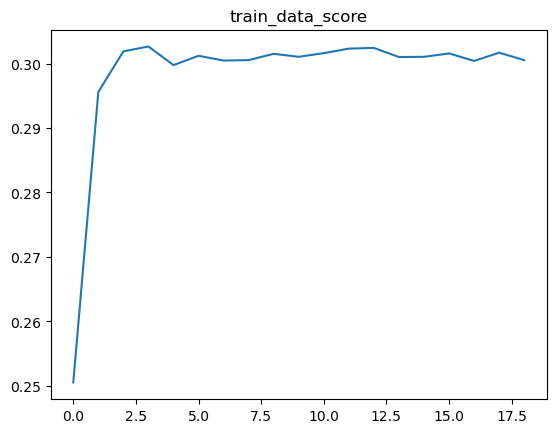

Top value:0.262, Bottom value:0.233


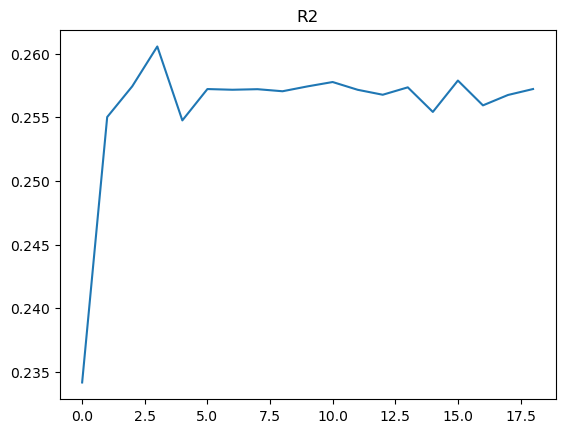

Top value:10.930, Bottom value:10.721


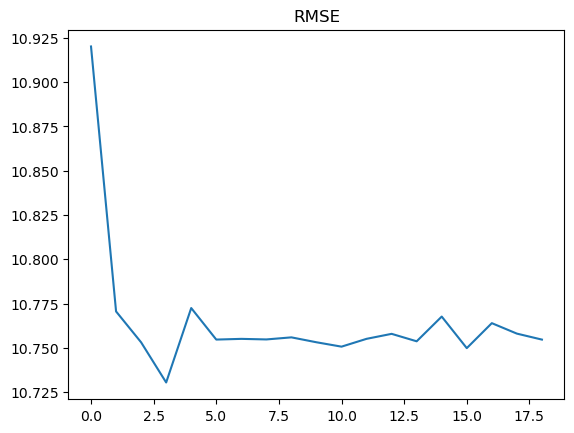

Top value:0.320, Bottom value:0.310


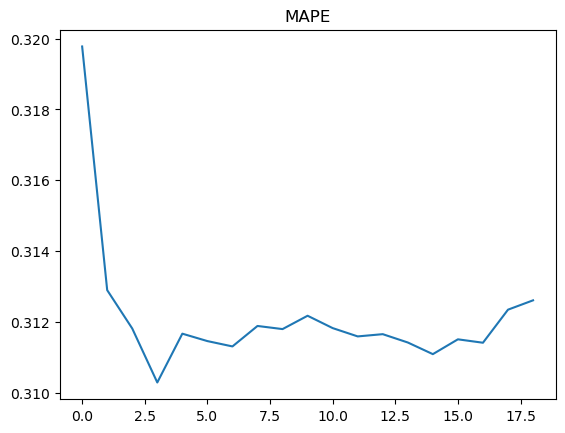

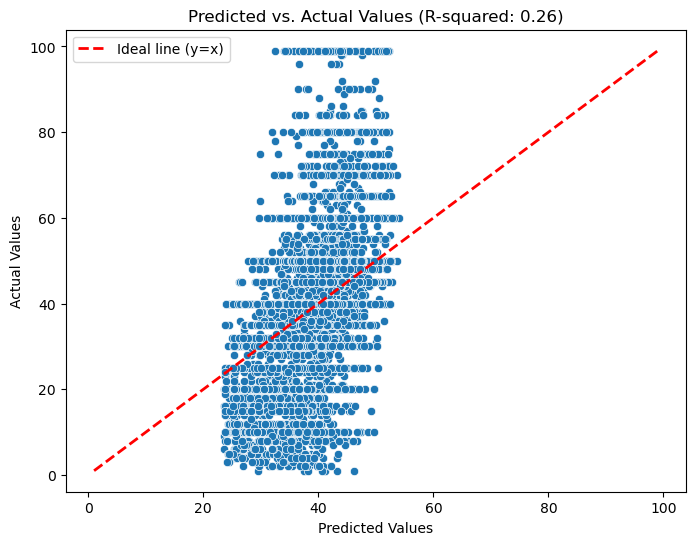

In [9]:
plt.plot(train_data_score)
bottom,top= plt.ylim()
print(f"Top value:{top:.3f}, Bottom value:{bottom:.3f}")
plt.title('train_data_score')
plt.show()

plt.plot(R2)
bottom,top= plt.ylim()
print(f"Top value:{top:.3f}, Bottom value:{bottom:.3f}")
plt.title('R2')
plt.show()

plt.plot(RMSE)
bottom,top= plt.ylim()
print(f"Top value:{top:.3f}, Bottom value:{bottom:.3f}")
plt.title('RMSE')
plt.show()

plt.plot(MAPE)
bottom,top= plt.ylim()
print(f"Top value:{top:.3f}, Bottom value:{bottom:.3f}")
plt.title('MAPE')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pred_y, y=test_y)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], linestyle='--', color='red', linewidth=2, label='Ideal line (y=x)')
plt.title(f'Predicted vs. Actual Values (R-squared: {r2_score(test_y,pred_y):.2f})')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend()
plt.show()

-----

### XGBoost

#### Model Construct

In [10]:
train_x = train_nd.drop("hours-per-week",axis=1)
train_y = train_nd['hours-per-week']

test_x = test_nd.drop("hours-per-week",axis=1)
test_y = test_nd['hours-per-week']

In [12]:
import xgboost as xgb
import time

startT = time.time()

# build XGBRegressor model
xgbrModel = xgb.XGBRegressor()
# Training
xgbrModel.fit(train_x,train_y.ravel())

endT = time.time()
print('執行時間:', endT-startT)

執行時間: 3.128563404083252


#### Evaluation

In [13]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

# Prediction
predicted = xgbrModel.predict(test_x)
  
r2 = r2_score(test_y, predicted)
print('R2 Score:{0}'.format(r2))

rmse = np.sqrt(mean_squared_error(test_y, predicted))
print('RMSE:{0}'.format(rmse))

mape = mean_absolute_percentage_error(test_y, predicted)
print('MAPE:{0}'.format(mape))

R2 Score:0.19772731320342152
RMSE:11.176968994837221
MAPE:0.33417223972218285


----

### SVR

#### Model Construct

In [ ]:
from sklearn.svm import SVR
from math import sqrt
import time

train_x = train_nd.drop("hours-per-week",axis=1)
train_x = train_x.sort_index(axis=1)
train_y = train_nd['hours-per-week']

test_x = test_nd.drop("hours-per-week",axis=1)
test_x = test_x.sort_index(axis=1)
test_y = test_nd['hours-per-week']

start=time.time()
model = SVR(C=200,max_iter=1000000,cache_size=1000)
model=model.fit(train_x,train_y.ravel())  #fit the model
end=time.time()
pred_y=model.predict(test_x) #make prediction on test set



c:\Users\mb207\anaconda3\envs\dm1\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


#### Evaluation

In [ ]:
error_RMSE = np.sqrt(mean_squared_error(test_y,pred_y)) #calculate rmse
error_MAPE = mean_absolute_percentage_error(test_y,pred_y)
error_r2 = r2_score(test_y,pred_y) 

print('RMSE value is:', round(error_RMSE,3))
print('MAPE value is:', round((error_MAPE*100),2),'%')
print('r_squared_value:', round(error_r2,3))
print('執行時間:',end-start)

RMSE value is: 11.008
MAPE value is: 29.81 %
r_squared_value: 0.222
執行時間: 448.3206076622009


---------